# Benchmark Analysis

In [1]:
%cd ..

/home/rotaldf/projects/msc-thesis-code/activesecuritympc


/home/rotaldf/projects/msc-thesis-code/python_zkp_venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoLocator
from matplotlib.ticker import ScalarFormatter
from matplotlib.transforms import Bbox
import numpy as np
import os

In [3]:
if not os.path.exists("figures"):
    os.makedirs("figures")

In [4]:
passive_readings = []
for i in range(3, 26):
    file = f"benchmarks/sum_passive_{i}_parties.csv"
    passive_readings.append(pd.read_csv(file))
passive_readings = pd.concat(passive_readings)
passive_readings['total_communication_cost'] = passive_readings['total_bytes_sent'] + passive_readings['total_bytes_recv']
passive_readings = passive_readings.drop(columns=['total_bytes_sent', 'total_bytes_recv'])

groth16_readings = []
for i in range(3, 26):
    file = f"benchmarks/sum_active_groth16_{i}_parties.csv"
    groth16_readings.append(pd.read_csv(file))
groth16_readings = pd.concat(groth16_readings)
# Group by 'parties' and 'ensemble' and set 'total_crs_generation_time' to the value of id==0 for each group
groth16_readings['total_crs_generation_time'] = groth16_readings.groupby(['parties', 'ensemble'])['total_crs_generation_time'].transform(lambda x: x.iloc[0])
groth16_readings['total_communication_cost'] = groth16_readings['total_bytes_sent'] + groth16_readings['total_bytes_recv']
groth16_readings['total_verification_time_per_party'] = groth16_readings['total_verification_time'] / groth16_readings['parties']
groth16_readings = groth16_readings.drop(columns=['total_bytes_sent', 'total_bytes_recv'])

bulletproofs_readings = []
for i in range(3, 26):
    file = f"benchmarks/sum_active_bulletproofs_{i}_parties.csv"
    bulletproofs_readings.append(pd.read_csv(file))
bulletproofs_readings = pd.concat(bulletproofs_readings)
bulletproofs_readings['total_communication_cost'] = bulletproofs_readings['total_bytes_sent'] + bulletproofs_readings['total_bytes_recv']
bulletproofs_readings['total_verification_time_per_party'] = bulletproofs_readings['total_verification_time'] / bulletproofs_readings['parties']
bulletproofs_readings = bulletproofs_readings.drop(columns=['total_bytes_sent', 'total_bytes_recv'])

parties = range(3,26)

In [5]:
def get_all_measurements_alongside_median(data, pivot_column):
    # Group by 'parties' and 'id'
    grouped_data = data.groupby(['parties', 'id'])
    std_data = grouped_data.std()
    std_data = std_data.drop(columns='ensemble')

    # Calculate the median of the pivot_column for each group
    median_values = grouped_data[pivot_column].median()

    # Find the row with the closest value to the median pivot_column value
    median_data = pd.DataFrame([])
    for group, median_value in median_values.items():
        close_values = data[(data['parties'] == group[0]) & (data['id'] == group[1])]
        closest_values = close_values.loc[close_values[pivot_column].sub(median_value).abs().idxmin()]
        median_data = pd.concat([median_data, pd.DataFrame([closest_values])], ignore_index=False)

    median_data = median_data.drop(columns='ensemble')
    return median_data, std_data

In [6]:
def produce_plot(fig, ax, data, metric_dict, name, metric='total_runtime', std=True, median_column='total_runtime', id=0, semilog=False, marker='o', linestyle='-', color='0', loc='upper left'):
    median_data, std_data = get_all_measurements_alongside_median(data, median_column)
    
    # Get data specifically for selected party
    data_party = median_data[median_data['id'] == id]
    std_data_party = std_data[std_data.index.get_level_values('id') == id]
    
    # Produce plot for a given metric
    parties = data_party['parties']
    specific_data = data_party[metric]
    std_dev = std_data_party[metric]
    
    if std:
        ax.errorbar(parties, specific_data, yerr=std_dev, marker=marker, linestyle=linestyle, linewidth=1, capsize=3, markersize=6, color=color, label=name)
    else:
        ax.plot(parties, specific_data, marker=marker, linestyle=linestyle, linewidth=1, markersize=6, color=color, label=name)
        
    ax.minorticks_on()
    if semilog:
        ax.set_yscale('log')  # Set y-axis to logarithmic scale
        # Add major grid lines for better readability
        ax.yaxis.grid(True, linestyle='-', alpha=0.3)
        # Add minor grid lines as dotted lines
        ax.yaxis.grid(which='minor', linestyle='--', alpha=0.15)
    ax.xaxis.set_major_locator(AutoLocator())
    ax.set_xlim(3-0.5, max(parties)+0.5)
    ax.set_xlabel('parties', fontsize=12)
    ax.set_ylabel(metric_dict[metric], fontsize=12)
    if name:
        ax.legend(loc=loc, fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)

    
    return fig, ax, specific_data

In [7]:
names = {
    "total_zkp_constraints": "constraints",
    "total_zkp_compile_time": "time (sec)",
    "total_proof_size": "size (bytes)",
    "total_proving_time": "time (sec)",
    "total_crs_generation_time": "time (sec)",
    "total_crs_len": "size (bytes)",
    "total_verification_time": "time (sec)",
    "total_verification_time_per_party": "time (sec)",
    "cache_size": "size (bytes)",
    "total_runtime": "time (sec)",
    "total_communication_cost": "data (bytes)",
    "setup_time": "time (sec)",
    "engagement_time": "time (sec)",
    "emulation_time": "time (sec)",
    "total_communication_time": "time (sec)",
}

## Analysis

We start with the basics, i.e. overall runtime and communication cost for passive, active (groth16) and active (bulletproofs), as well as storage/memory usage for active (groth16) and active (bulletproofs)

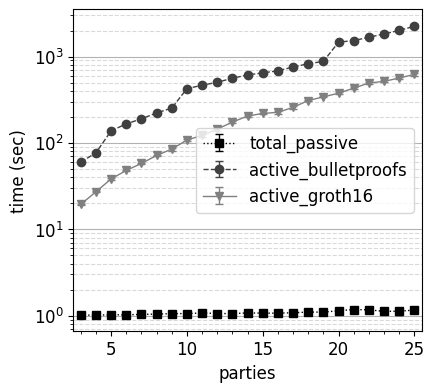

In [27]:
# Total runtime
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, passive_readings, names, "total_passive", "total_runtime", median_column="total_runtime", marker='s', linestyle='dotted', color='0', loc='best')
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "active_bulletproofs", "total_runtime", median_column="total_runtime", marker='o', linestyle='--', color='0.25', loc='best')
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "active_groth16", "total_runtime", median_column="total_runtime", marker='v', linestyle='-', color='0.5', loc='best', semilog=True)
fig.savefig('figures/total_runtime.pdf')

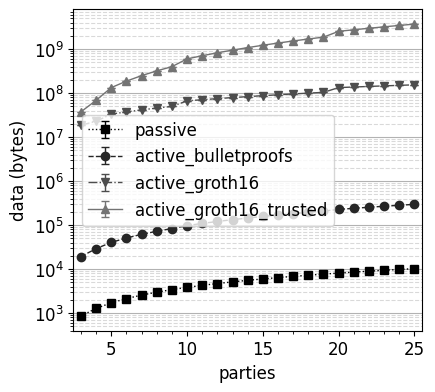

In [9]:
# Total communication cost
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, passive_readings, names, "passive", "total_communication_cost", median_column="total_communication_cost", marker='s', linestyle='dotted', color='0', loc='best')
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "active_bulletproofs", "total_communication_cost", median_column="total_communication_cost", marker='o', linestyle='--', color='0.15', loc='best')
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "active_groth16", "total_communication_cost", median_column="total_communication_cost", id=1, marker='v', linestyle='-.', color='0.3', loc='best')
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "active_groth16_trusted", "total_communication_cost", median_column="total_communication_cost", marker='^', linestyle='-', color='0.45', loc='best', semilog=True)
# plt.subplots_adjust(left=0.15)
fig.savefig('figures/total_communication_cost.pdf')

Clearly active security is far more expensive than passive security
* regarding the runtime, it at least 1 and upwards of 2 orders of magnitude slower (groth < bulletproofs differ by half order of magnitude), and follows an exponential trend.
* regarding communication cost, active security using bulletproofs is a bit over 1 order of magnitude more expensive and follows a linear trend. Active security using groth16 is over 4 orders of magnitude more expensive when it is not the trusted party, and becomes increasingly more expensive when it is.

The last thing we want to look at in terms of overall performance, is the total cache storage that is required by the active security compiler

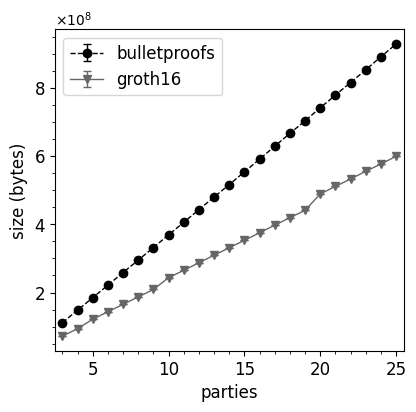

In [10]:
# Cache (memory) size
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "bulletproofs", "cache_size", median_column="cache_size", marker='o', linestyle='--', color='0')
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "groth16", "cache_size", median_column="cache_size", marker='v', linestyle='-', color='0.4', semilog=False)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
fig.savefig('figures/active_cache.pdf')

### Breakdown of runtime over the different active security compiler phases

To understand why active security with bulletproofs requires more computation time, let's break down the runtime analysis into its parts

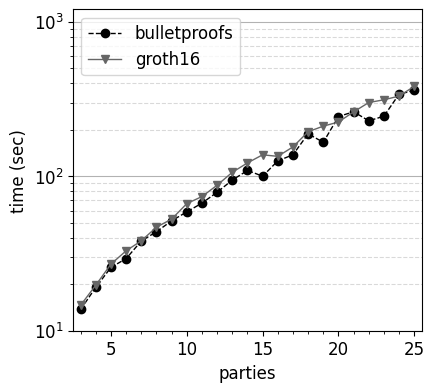

In [11]:
# Setup time
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "bulletproofs", "setup_time", median_column="total_runtime", std=False, marker='o', linestyle='--', color='0')
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "groth16", "setup_time", median_column="total_runtime", std=False, marker='v', linestyle='-', color='0.4', semilog=True)
plt.ylim(10, 1200)
fig.savefig('figures/active_setup_time.pdf')

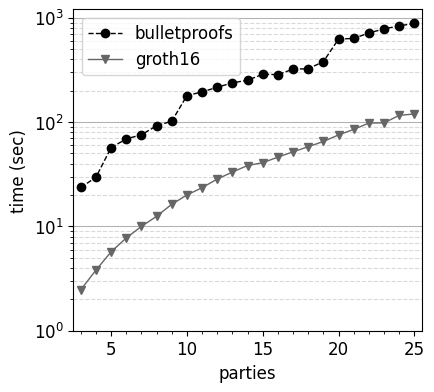

In [12]:
# Engagement time
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "bulletproofs", "engagement_time", median_column="total_runtime", std=False, marker='o', linestyle='--', color='0')
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "groth16", "engagement_time", median_column="total_runtime", std=False, marker='v', linestyle='-', color='0.4', semilog=True)
plt.ylim(1, 1200)
fig.savefig('figures/active_engagement_time.pdf')

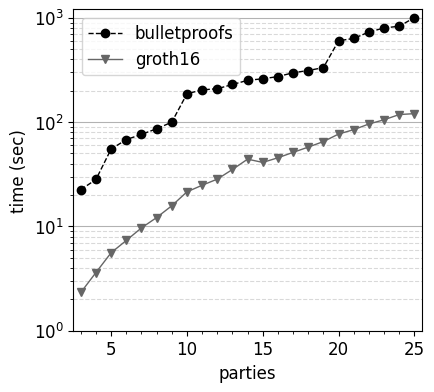

In [13]:
# Emulation time
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "bulletproofs", "emulation_time", median_column="total_runtime", std=False, marker='o', linestyle='--', color='0')
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "groth16", "emulation_time", median_column="total_runtime", std=False, marker='v', linestyle='-', color='0.4', semilog=True)
plt.ylim(1, 1200)
fig.savefig('figures/active_emulation_time.pdf')

For the setup phase, it appears that both groth16 and bulletproofs are quite similar, but groth16 is a bit slower due to the trusted setup. Moreover, engagement and emulation are both similar where active security with bulletproofs is about 1 order of magnitude slower than with groth16.

### Breakdown of setup phase

We measure the runtime and size of the components in setup phase, more specifically the ZKP compilation runtime and number of constraints, and the CRS generation runtime and size:

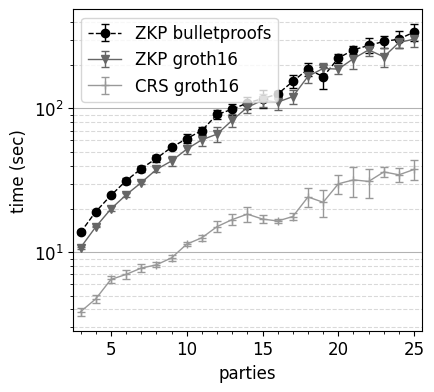

In [14]:
# Total CRS generation and ZKP compilation time
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, d1 = produce_plot(fig, ax, bulletproofs_readings, names, "ZKP bulletproofs", "total_zkp_compile_time", median_column="total_zkp_compile_time", marker='o', linestyle='--', color='0')
fig, ax, d2 = produce_plot(fig, ax, groth16_readings, names, "ZKP groth16", "total_zkp_compile_time", median_column="total_zkp_compile_time", marker='v', linestyle='-', color='0.4')
fig, ax, d3 = produce_plot(fig, ax, groth16_readings, names, "CRS groth16", "total_crs_generation_time", median_column="total_crs_generation_time", marker='+', linestyle='-', color='0.6', semilog=True)
fig.savefig('figures/zkp_comp_crs_gen.pdf')

We see that ZKP compilation time has an exponential trend, while CRS generation time seems to follow more of a linear trend. Also, since ZKP generation for groth16 is consistantly faster than ZKP generation for bulletproofs and since the magnitude is significantly higher than CRS generation, it justifies why the setup phase runtimes are similar for bulletproofs and groth16.

Next, we want to understand whewre this difference in ZKP compilation may come from. Let's look at the number of constraints forh groth16 and bulletproofs and their difference

In [15]:
_, _, constraints_groth16 = produce_plot(fig, ax, groth16_readings, names, "", "total_zkp_constraints")
_, _, constraints_bulletproofs = produce_plot(fig, ax, bulletproofs_readings, names, "", "total_zkp_constraints")
zk_constraints = pd.DataFrame(zip(list(constraints_groth16), list(constraints_bulletproofs)), columns=['groth16', 'bulletproofs'])
zk_constraints["difference"] = zk_constraints["groth16"] - zk_constraints["bulletproofs"] 

In [16]:
zk_constraints

,groth16,bulletproofs,difference
0,40866.0,40668.0,198.0
1,54518.0,54253.0,265.0
2,68174.0,67844.0,330.0
3,81838.0,81441.0,397.0
4,95510.0,95044.0,466.0
5,109183.0,108653.0,530.0
6,122867.0,122274.0,593.0
7,136556.0,135896.0,660.0
8,150243.0,149523.0,720.0
9,163949.0,163157.0,792.0


While it is not surprising that bulletproofs require fewer constraints (smaller prime field modulus), it is surprising that the ZKP compilation time is slower. Understanding why is beyond the scope, could be because of ECC operations, or optimization of specific R1CS

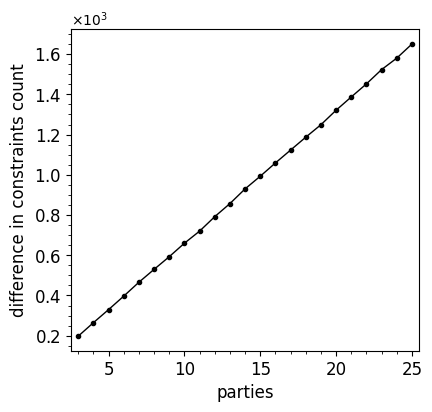

In [17]:
# Total ZKP constraints
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')

ax.plot(parties, zk_constraints["difference"], marker=".", linestyle="-", linewidth=1, markersize=6, color="0")
    
ax.minorticks_on()
ax.xaxis.set_major_locator(AutoLocator())
ax.set_xlim(3-0.5, max(parties)+0.5)
ax.set_xlabel('parties', fontsize=12)
ax.set_ylabel("difference in constraints count", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# plt.subplots_adjust(left=0.15)
fig.savefig('figures/constraints_count.pdf')

Moreover, difference is not perfectly linear (but close enough)

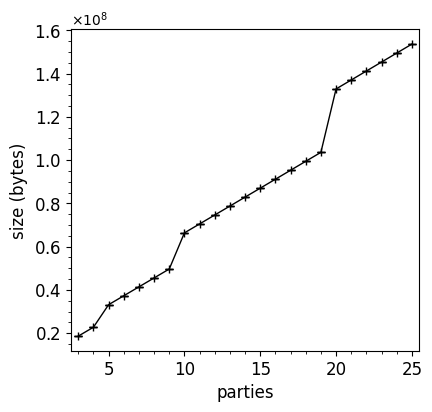

In [18]:
# Total CRS length
fig, ax = plt.subplots(figsize=(6.75*2/3, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "", "total_crs_len", marker='+', semilog=False)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
fig.savefig('figures/crs_length.pdf')

ZKP constraints are clearly linear with party size, while CRS length is linear but has steep increments at m=5, m=9 and m=20

### Breakdown of engagement and emulation phase

Both engagement and emulation essentially are limited by the ZKP proofs and verifications.  We inspect the components as follows

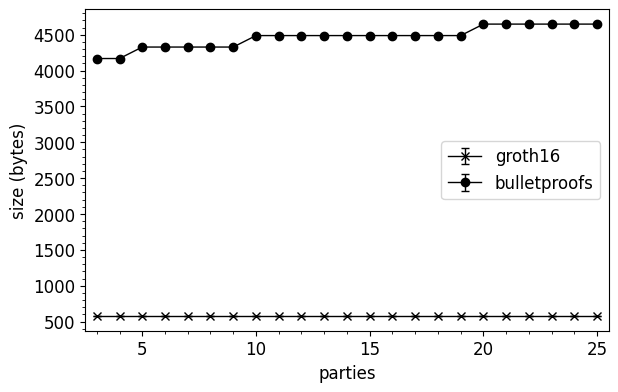

In [19]:
# Total CRS length and ZKP constraints
fig, ax = plt.subplots(figsize=(6.75, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "groth16", "total_proof_size", marker='x', semilog=False, loc="best")
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "bulletproofs", "total_proof_size", marker='o', semilog=False,  loc="best")
fig.savefig('figures/active_bulletproofs_proof_size.pdf')

Groth16 always produces constant size proofs, whereas Bulletproofs are sublinear in the size of number of constraints, and can be explained by number of generators required being a power of 2 w.r.t number of constraints/multiplications

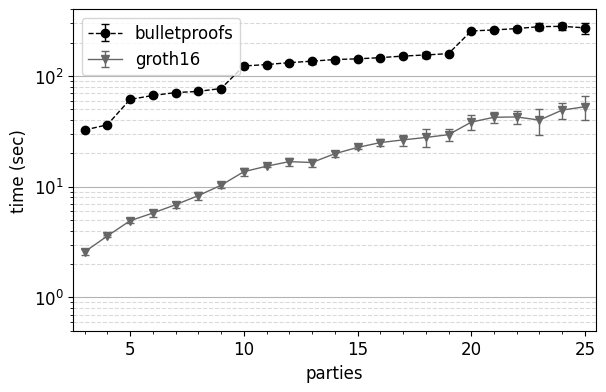

In [20]:
# Total proving time
fig, ax = plt.subplots(figsize=(6.75, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "bulletproofs", "total_proving_time", median_column="total_proving_time", marker='o', linestyle='--', color='0')
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "groth16", "total_proving_time", median_column="total_proving_time", marker='v', linestyle='-', color='0.4', semilog=True)
plt.ylim(0.5, 400)
fig.savefig('figures/active_proving_time.pdf')

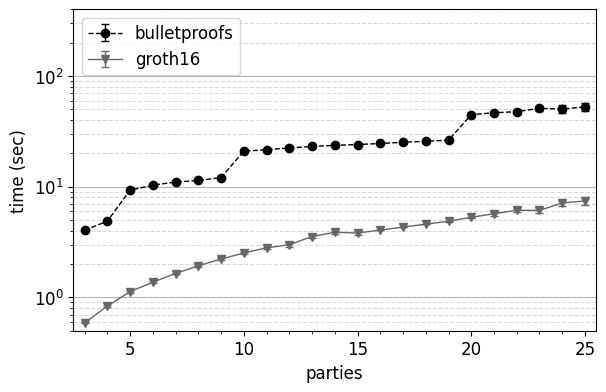

In [21]:
# Total verification time per party
fig, ax = plt.subplots(figsize=(6.75, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "bulletproofs", "total_verification_time_per_party", median_column="total_verification_time_per_party", marker='o', linestyle='--', color='0')
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "groth16", "total_verification_time_per_party", median_column="total_verification_time_per_party", marker='v', linestyle='-', color='0.4', semilog=True)
plt.ylim(0.5, 400)
fig.savefig('figures/active_verification_time.pdf')

### Relative runtimes

In [22]:
def get_runtime_ratio(data, metric_dict, metric='runtime', id=0):
    median_data, _ = get_all_measurements_alongside_median(data, "total_runtime")
    
    # Compute a new column based on metric divided by total_runtime
    median_data_ratio = median_data[metric] / median_data['total_runtime']
    
    # Get data specifically for party 0
    median_data_0 = median_data_ratio[median_data['id'] == id]

    return median_data_0

Lastly we measure how all components compare against the overall runtime and communication cost to see which is the bottleneck.

Runtime contributions:
* Components percentage plot: total_zkp_compile_time, total_crs_generation_time, total_proving_time, total_verification_time, remainder
* Phases percentage plot: setup_time, engagement_time, emulation_time, remainder

for cache it is kind of useless due to serialization of components, and for communication we only compare proof size to crs size (which depend on each other), so also not interesting.

#### Groth16

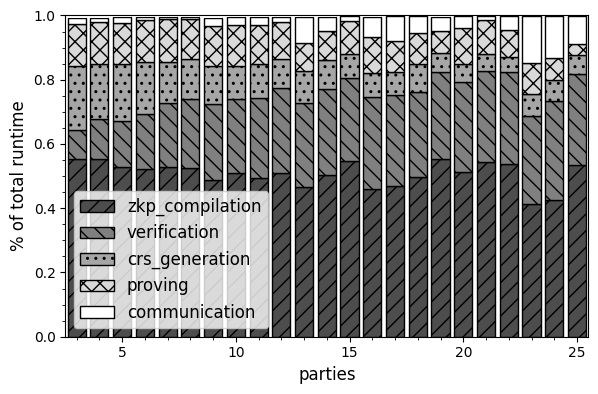

In [23]:
# For different components
zkp_compile_time_ratio = get_runtime_ratio(groth16_readings, names, "total_zkp_compile_time")
crs_generation_time_ratio = get_runtime_ratio(groth16_readings, names, "total_crs_generation_time")
proving_time_ratio = get_runtime_ratio(groth16_readings, names, "total_proving_time")
verification_time_ratio = get_runtime_ratio(groth16_readings, names, "total_verification_time")
communication_time_ratio = get_runtime_ratio(groth16_readings, names, "total_communication_time")

remainder_ratio = 1 - (zkp_compile_time_ratio + crs_generation_time_ratio + proving_time_ratio + verification_time_ratio + communication_time_ratio)

bar_width = 0.8
bar_positions = parties
patterns = [ "//" , "\\\\" , ".." , "xx" , "" , "x", "o", "O", ".", "*" ]

plt.figure(figsize=(6.75, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
plt.bar(bar_positions, zkp_compile_time_ratio, width=bar_width, hatch=patterns[0], edgecolor='black', color='0.3', label="zkp_compilation")
plt.bar(bar_positions, verification_time_ratio, width=bar_width, hatch=patterns[1], edgecolor='black', color='0.5', bottom=zkp_compile_time_ratio, label="verification")
plt.bar(bar_positions, crs_generation_time_ratio, width=bar_width, hatch=patterns[2], edgecolor='black', color='0.65', bottom=zkp_compile_time_ratio+verification_time_ratio, label="crs_generation")
plt.bar(bar_positions, proving_time_ratio, width=bar_width, hatch=patterns[3], edgecolor='black', color='0.85', bottom=zkp_compile_time_ratio+verification_time_ratio+crs_generation_time_ratio, label="proving")
plt.bar(bar_positions, communication_time_ratio, width=bar_width, hatch=patterns[4], edgecolor='black', color='1', bottom=zkp_compile_time_ratio+verification_time_ratio+crs_generation_time_ratio+proving_time_ratio, label="communication")
plt.bar(bar_positions, remainder_ratio, width=bar_width, color='1', bottom=zkp_compile_time_ratio+verification_time_ratio+crs_generation_time_ratio+proving_time_ratio+communication_time_ratio)
plt.minorticks_on()

plt.xlim(3-0.5, max(parties)+0.5)
plt.ylim(0, 1)
plt.xlabel('parties', fontsize=12)
plt.ylabel('% of total runtime', fontsize=12)
plt.legend(loc='lower left', fontsize=12)

plt.savefig('figures/groth16_relative_component_times.pdf')

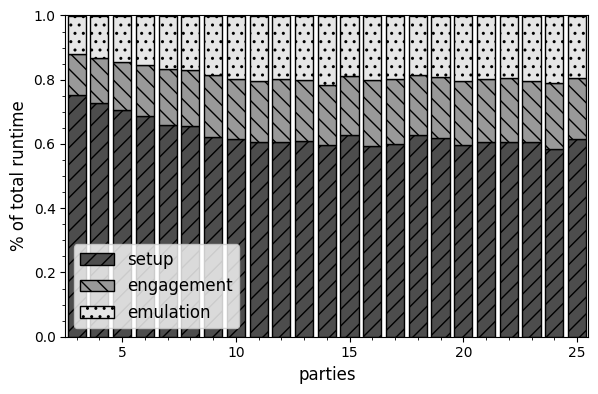

In [24]:
# For different phases
setup_time_ratio = get_runtime_ratio(groth16_readings, names, "setup_time")
engagement_time_ratio = get_runtime_ratio(groth16_readings, names, "engagement_time")
emulation_time_ratio = get_runtime_ratio(groth16_readings, names, "emulation_time")

remainder_ratio = 1 - (setup_time_ratio + engagement_time_ratio + emulation_time_ratio)

bar_width = 0.8
bar_positions = parties
patterns = [ "//" , "\\\\" , ".." , "xx" , "" , "x", "o", "O", ".", "*" ]

plt.figure(figsize=(6.75, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
plt.bar(bar_positions, setup_time_ratio, width=bar_width, hatch=patterns[0], edgecolor='black', color='0.3', label="setup")
plt.bar(bar_positions, engagement_time_ratio, width=bar_width, hatch=patterns[1], edgecolor='black', color='0.6', bottom=setup_time_ratio, label="engagement")
plt.bar(bar_positions, emulation_time_ratio, width=bar_width, hatch=patterns[2], edgecolor='black', color='0.9', bottom=setup_time_ratio+engagement_time_ratio, label="emulation")
plt.bar(bar_positions, remainder_ratio, width=bar_width, color='1', bottom=setup_time_ratio+engagement_time_ratio+emulation_time_ratio)

plt.minorticks_on()

plt.xlim(3-0.5, max(parties)+0.5)
plt.ylim(0, 1)
plt.xlabel('parties', fontsize=12)
plt.ylabel('% of total runtime', fontsize=12)
plt.legend(loc='best', fontsize=12)

plt.savefig('figures/groth16_relative_phases_times.pdf')

#### Bulletproofs

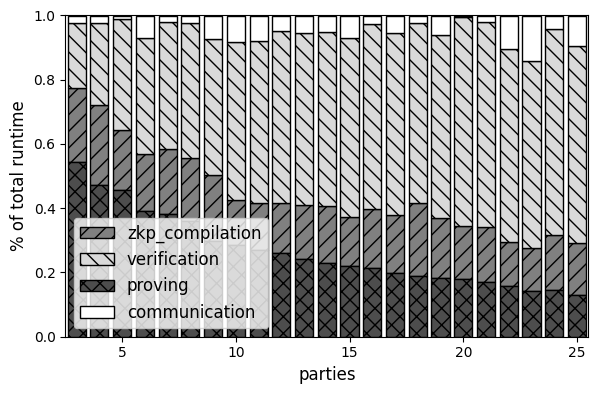

In [25]:
# For different components
zkp_compile_time_ratio = get_runtime_ratio(bulletproofs_readings, names, "total_zkp_compile_time")
proving_time_ratio = get_runtime_ratio(bulletproofs_readings, names, "total_proving_time")
verification_time_ratio = get_runtime_ratio(bulletproofs_readings, names, "total_verification_time")
communication_time_ratio = get_runtime_ratio(bulletproofs_readings, names, "total_communication_time")

remainder_ratio = 1 - (zkp_compile_time_ratio + proving_time_ratio + verification_time_ratio + communication_time_ratio)

bar_width = 0.8
bar_positions = parties
patterns = [ "//" , "\\\\" , ".." , "xx" , "" , "x", "o", "O", ".", "*" ]

plt.figure(figsize=(6.75, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
plt.bar(bar_positions, zkp_compile_time_ratio, width=bar_width, hatch=patterns[0], edgecolor='black', color='0.5', bottom=proving_time_ratio, label="zkp_compilation")
plt.bar(bar_positions, verification_time_ratio, width=bar_width, hatch=patterns[1], edgecolor='black', color='0.85', bottom=proving_time_ratio+zkp_compile_time_ratio, label="verification")
plt.bar(bar_positions, proving_time_ratio, width=bar_width, hatch=patterns[3], edgecolor='black', color='0.3', label="proving")
plt.bar(bar_positions, communication_time_ratio, width=bar_width, hatch=patterns[4], edgecolor='black', color='1', bottom=proving_time_ratio+zkp_compile_time_ratio+verification_time_ratio, label="communication")
plt.bar(bar_positions, remainder_ratio, width=bar_width, color='0.75', bottom=proving_time_ratio+zkp_compile_time_ratio+verification_time_ratio+communication_time_ratio)


plt.xlim(3-0.5, max(parties)+0.5)
plt.ylim(0, 1)
plt.xlabel('parties', fontsize=12)
plt.ylabel('% of total runtime', fontsize=12)
plt.legend(loc='lower left', fontsize=12)

plt.savefig('figures/bulletproofs_relative_component_times.pdf')

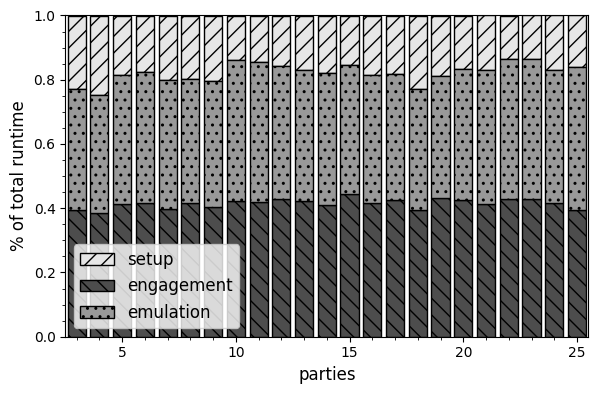

In [26]:
# For different phases
runtime_ratio = get_runtime_ratio(bulletproofs_readings, names, "total_runtime")
setup_time_ratio = get_runtime_ratio(bulletproofs_readings, names, "setup_time")
engagement_time_ratio = get_runtime_ratio(bulletproofs_readings, names, "engagement_time")
emulation_time_ratio = get_runtime_ratio(bulletproofs_readings, names, "emulation_time")

remainder_ratio = 1 - (setup_time_ratio + engagement_time_ratio + emulation_time_ratio)

bar_width = 0.8
bar_positions = parties
patterns = [ "//" , "\\\\" , ".." , "xx" , "" , "x", "o", "O", ".", "*" ]

plt.figure(figsize=(6.75, 2.0858647120308955*2), facecolor="white")
plt.style.use('grayscale')
plt.bar(parties, setup_time_ratio, width=bar_width, hatch=patterns[0], edgecolor='black', color='0.9', bottom=engagement_time_ratio+emulation_time_ratio, label="setup")
plt.bar(parties, engagement_time_ratio, width=bar_width, hatch=patterns[1], edgecolor='black', color='0.3', label="engagement")
plt.bar(parties, emulation_time_ratio, width=bar_width, hatch=patterns[2], edgecolor='black', color='0.6', bottom=engagement_time_ratio, label="emulation")
plt.bar(parties, remainder_ratio, width=bar_width, color='1', bottom=engagement_time_ratio+emulation_time_ratio+setup_time_ratio)
plt.minorticks_on()

plt.xlim(3-0.5, max(parties)+0.5)
plt.ylim(0, 1)
plt.xlabel('parties', fontsize=12)
plt.ylabel('% of total runtime', fontsize=12)
plt.legend(loc='lower left', fontsize=12)

plt.savefig('figures/bulletproofs_relative_phases_times.pdf')